In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from convokit import Corpus, HyperConvo, TensorDecomposer, download

First we download the reddit corpus:

In [5]:
# corpus = Corpus(filename="convokit/thread_generator/fake-corpus-trajectory-40")
# corpus = Corpus(filename="convokit/thread_generator/annotated-fake-trajectory-40")
corpus = Corpus(download('reddit-corpus'))
# corpus = Corpus(filename="convokit/tensor_decomposer/experiments/reddit-trajectory-subset-annotated")

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus


In [6]:
corpus.print_summary_stats()

Number of Speakers: 521777
Number of Utterances: 2004262
Number of Conversations: 84979


### Data filtering

In [7]:
convo_ids = set(corpus.get_conversation_ids())

In [8]:
from convokit import Utterance, Speaker
filler_utts = [Utterance(id=cid, conversation_id=cid, speaker=Speaker(id='534rehwh3h')) for cid in convo_ids]

In [9]:
for utt in filler_utts:
    utt.timestamp = 0

In [10]:
corpus.add_utterances(filler_utts, warnings=True, with_checks=False)

In [11]:
full_convos = {c.id for c in corpus.iter_conversations() if c.check_integrity(verbose=False)}
len(full_convos)

84979

In [12]:
top_level_comment_ids = [utt.id for utt in corpus.iter_utterances() if utt.reply_to in convo_ids]
corpus = corpus.reindex_conversations(top_level_comment_ids)

In [13]:
corpus.print_summary_stats()

Number of Speakers: 521777
Number of Utterances: 2004262
Number of Conversations: 100000


## Encode deepen vs broaden

In [20]:
convo = corpus.random_conversation()

In [18]:
from collections import defaultdict
def encode_structural_change(convo):
    has_reply = defaultdict(list)
    for utt in convo.get_chronological_utterance_list():
        if utt.reply_to in has_reply:
            utt.meta['structure'] = 'broaden'
        else:
            utt.meta['structure'] = 'deepen'
        has_reply[utt.reply_to].append(utt.id)

In [21]:
convo.print_conversation_structure()

HeForeverBleeds
    girlwriteswhat
        noriann
            girlwriteswhat
                noriann
                    girlwriteswhat
                noriann
                    girlwriteswhat
                        noriann
                            girlwriteswhat
                                noriann
        HeForeverBleeds
            girlwriteswhat


In [22]:
encode_structural_change(convo)

In [24]:
convo.print_conversation_structure(lambda convo: convo.meta['structure'])

deepen
    deepen
        deepen
            deepen
                deepen
                    deepen
                broaden
                    deepen
                        deepen
                            deepen
                                deepen
        broaden
            deepen


In [25]:
for convo in corpus.iter_conversations():
    encode_structural_change(convo)

In [30]:
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(convo.get_chronological_utterance_list()[:10]):
        convo.meta[f'structure-dict-{idx+1}'] = {'broaden': int(utt.meta['structure'] == 'broaden'),
                                                 'deepen': int(utt.meta['structure'] == 'deepen')}

In [77]:
td = TensorDecomposer(feature_set=['structure-dict-{}'.format(idx) for idx in range(1, 9+1)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=9,
                     )

In [78]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.6533621492154214, improvement inf.
NCP_BCD: iteration 2, objective 0.618380697680505, improvement 0.034981451534916386.
NCP_BCD: iteration 3, objective 0.5968418441165285, improvement 0.021538853563976446.
NCP_BCD: iteration 4, objective 0.5716407997212748, improvement 0.025201044395253724.
NCP_BCD: iteration 5, objective 0.5501068323444018, improvement 0.021533967376872964.
NCP_BCD: iteration 6, objective 0.5337156855124403, improvement 0.016391146831961523.
NCP_BCD: iteration 7, objective 0.5180497896408508, improvement 0.015665895871589508.
NCP_BCD: iteration 8, objective 0.504360169658076, improvement 0.013689619982774848.
NCP_BCD: iteration 9, objective 0.49222788776188353, improvement 0.01213228189619242.
NCP_BCD: iteration 10, objective 0.4816352692041217, improvement 0.010592618557761835.
NCP_BCD: iteration 11, objective 0.4731996208108031, improvement 0.008435648393318618.
NCP_BCD: iteration 12,

Directory already exists. Exiting summarize()


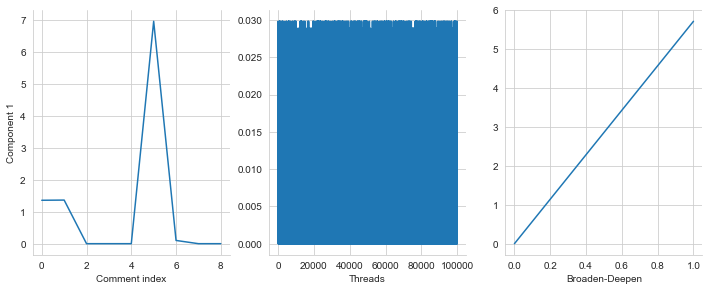

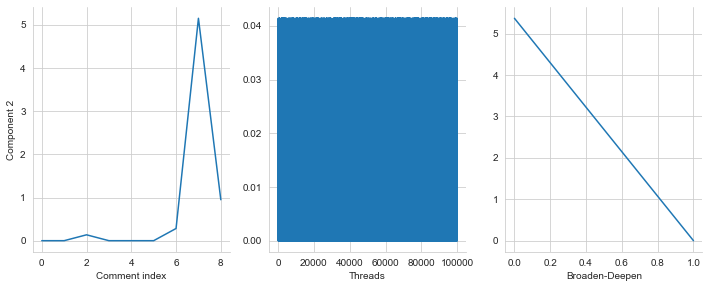

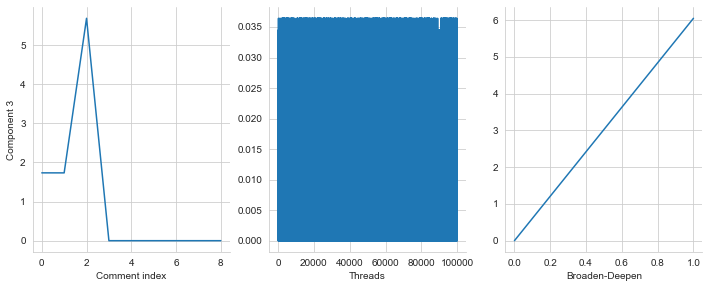

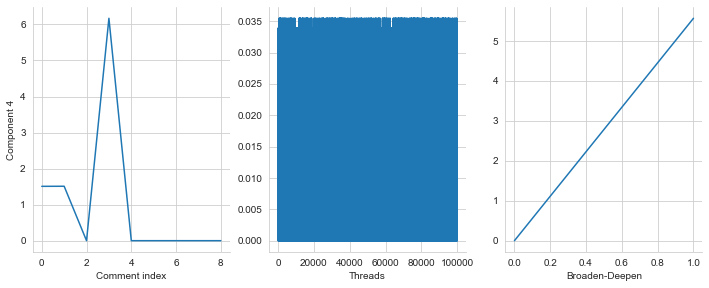

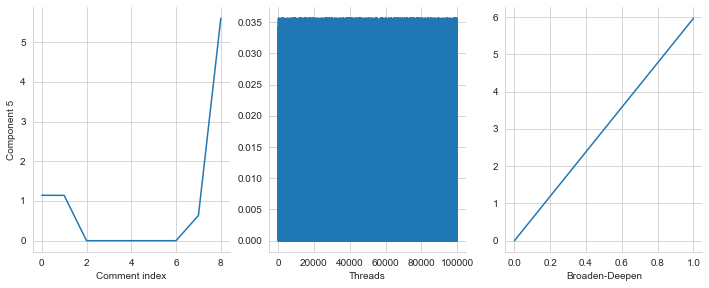

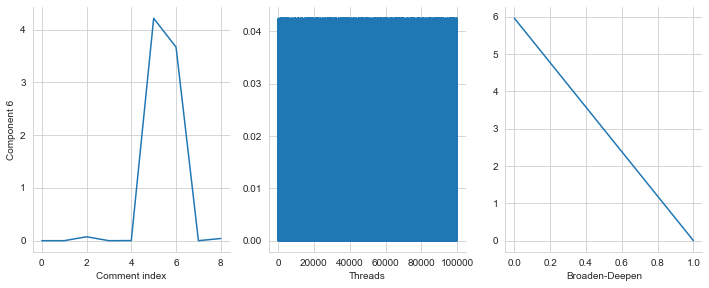

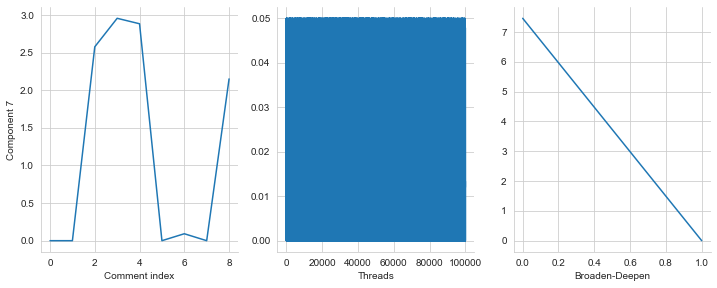

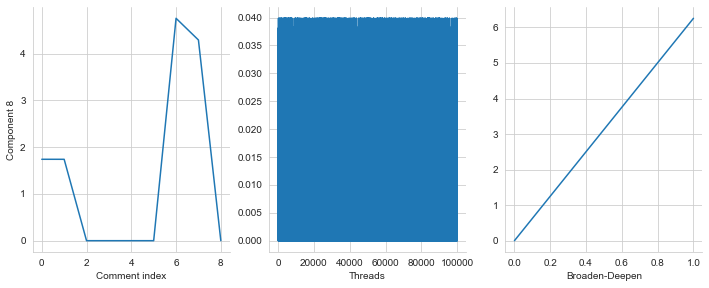

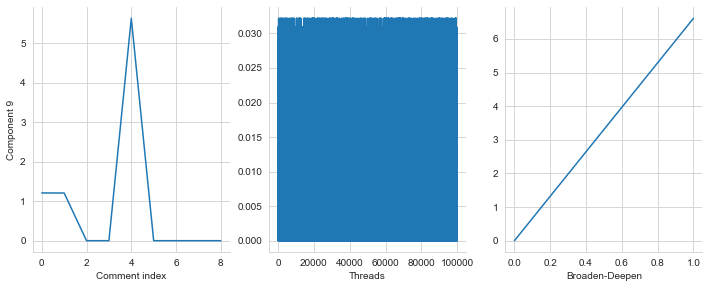

In [79]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Broaden-Deepen'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [80]:
td.transform(corpus)

### Label annotation

In [49]:
ctr = 0
for convo in corpus.iter_conversations():
    if convo.get_chronological_utterance_list()[9].meta['structure'] == 'broaden':
        ctr+=1

In [50]:
ctr

36855

In [51]:
for convo in corpus.iter_conversations():
    convo.meta['broadens'] = convo.get_chronological_utterance_list()[9].meta['structure'] == 'broaden'

### Tensor prediction

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])
svm_model = svm.SVC(C=0.02, kernel='linear', probability=True)

In [82]:
from convokit import BoWClassifier

In [90]:
clf_tensor = BoWClassifier(obj_type="conversation", vector_name='tensor_factor', labeller=lambda convo: convo.meta['broadens'],
                clf_feat_name='tensor-pred', clf_prob_feat_name='tensor-pred-score', clf=model
                )

In [91]:
from sklearn.model_selection import KFold

In [94]:
res = clf_tensor.evaluate_with_cv(corpus, cv=KFold(n_splits=5, shuffle=True))

Using corpus objects...

Running a cross-validated evaluation...
Done.


In [95]:
np.mean(res)

0.63251

In [97]:
clf_tensor.fit(corpus)

In [98]:
clf_tensor.get_coefs([f'component{idx}' for idx in range(1, 9+1)])

,coef
feat_name,
component6,0.651407
component8,0.446912
component2,0.427870
component1,0.391877
component7,0.068094
component3,-0.000362
component4,-0.028789
component9,-0.036631
component5,-0.040929


In [95]:
for convo in corpus.iter_conversations(selector=lambda convo: convo.meta['longest_path'] >= 14):
    convo.meta['tensor_rank20'] = convo.meta['tensor_factor']

## Combined feature sets

In [83]:
grown

730

### Hyperconvo-7 + TCA (rank 20)

In [49]:
for convo in corpus.iter_conversations(selector=lambda convo: convo.meta['longest_path'] >= 14):
    convo.meta['tensor_dict'] = {idx: v for idx, v in enumerate(convo.meta['tensor_factor'])}

In [50]:
clf_all = Classifier(obj_type="conversation", pred_feats=['hyperconvo-7', 'tensor_dict'], labeller=lambda convo: convo.meta['grown'],
                )

In [51]:
res = clf_all.evaluate_with_cv(corpus, selector=lambda convo: convo.meta['longest_path'] >= 14)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [52]:
np.mean(res)

0.9000540069196366